In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

import autograd
from autograd import numpy as np
from autograd import scipy as sp

import numpy as onp
import scipy as osp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Set up model

In [2]:
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha8.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Experimenting w GH points

In [4]:
# Refit with more GH points
gh_deg = 20

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=model.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.252659819113031	 Objective: -305.35833030090663
Iter: 1	 RMSE: 11.252659791490329	 Objective: -305.35833030091084
Optimization terminated successfully.
         Current function value: -305.358330
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. 


# Define perturbation

In [5]:
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

influence_class = fun_sens_lib.InfluenceFunction(model, 
                        input_par = e_num_clusters_class.model.global_vb_params, 
                        output_par = e_num_clusters_class.e_num_clusters, 
                        input_to_output_converter = e_num_clusters_class.set_e_num_clusters, 
                        optimal_input_par = best_param_0,
                        objective_hessian = kl_hessian_0)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [6]:
logit_theta = np.linspace(-10, 10, 100)

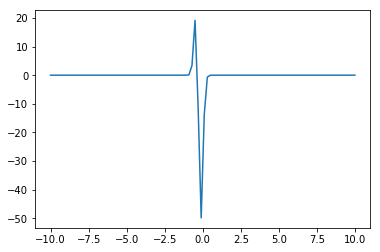

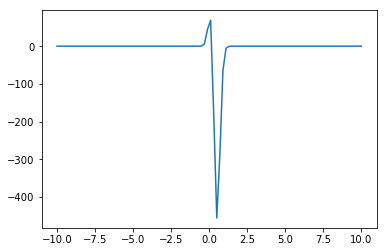

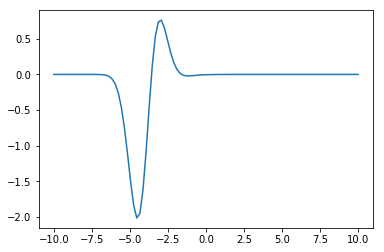

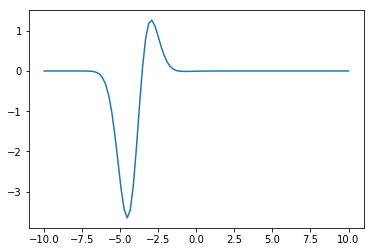

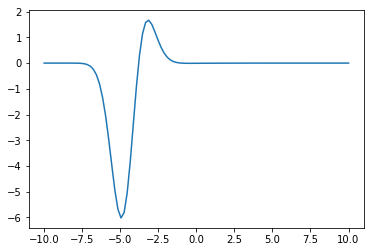

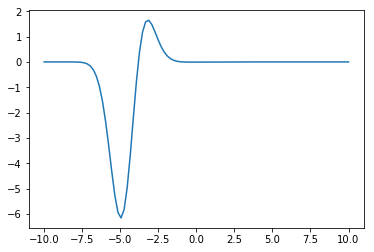

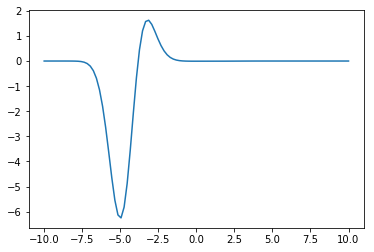

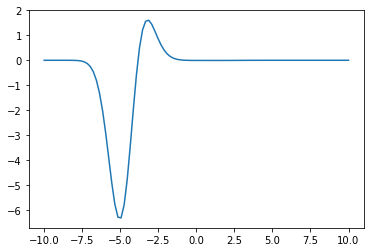

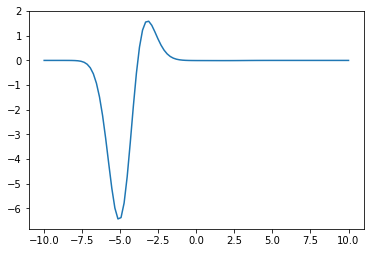

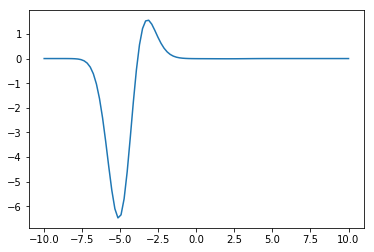

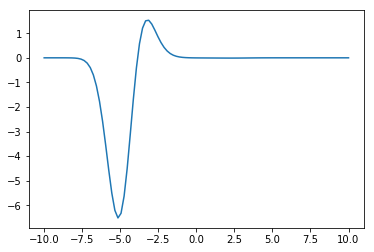

In [7]:
for k in range(model.k_approx - 1): 
    plt.figure()
    plt.plot(logit_theta, influence_class.get_influence_function_k(logit_theta, k).squeeze())

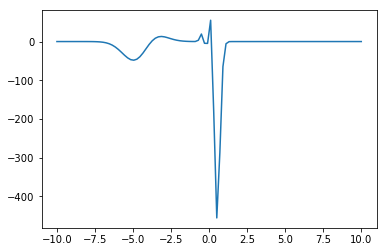

In [8]:
plt.plot(logit_theta, influence_class.get_influence_function(logit_theta))

In [9]:
import interpolation_lib as interp_lib

In [10]:
x_reg = np.linspace(-10, 10, 100)
knot_vector = x_reg
order = 3

In [11]:
logit_influence_fun_interp = interp_lib.BsplineRegression(influence_class.get_influence_function, 
                                                          x_reg, knot_vector, order)

condition number:  8.91187815224694


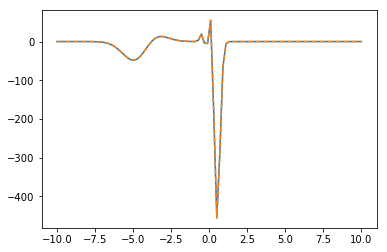

In [12]:
plt.plot(logit_theta, logit_influence_fun_interp.eval_fun(logit_theta))
plt.plot(logit_theta, logit_influence_fun_interp.eval_interp_fun(logit_theta), '--')

In [13]:
x_test = np.random.rand(1000) * 20 - 10

true_fun = logit_influence_fun_interp.eval_fun(x_test)
interp_fun = logit_influence_fun_interp.eval_interp_fun(x_test)

np.max(np.abs(true_fun - interp_fun) / np.maximum(np.abs(true_fun), 1e-6))

13.42408774704465

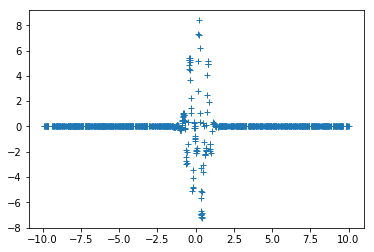

In [14]:
plt.plot(x_test, true_fun - interp_fun, '+')

In [15]:
# Define a perturbation in the logit v space.

# phi_center = -2
# #phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
# phi_log_rescale = -np.log(0.5)
# print(phi_log_rescale)

# def log_phi(logit_v):
#     return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))
# prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi)
# print(
#     prior_perturbation.log_norm_p0,
#     prior_perturbation.log_norm_pc,
#     prior_perturbation.log_norm_p0_logit,
#     prior_perturbation.log_norm_pc_logit)

In [76]:
def log_phi_pos(logit_v): 
    # pos whether we look at worst case positive perturbation
    return np.log(np.maximum(logit_influence_fun_interp.eval_interp_fun(logit_v), 1e-12))

def log_phi_neg(logit_v): 
    # pos whether we look at worst case positive perturbation
    return np.log(np.maximum(-logit_influence_fun_interp.eval_interp_fun(logit_v), 1e-12))



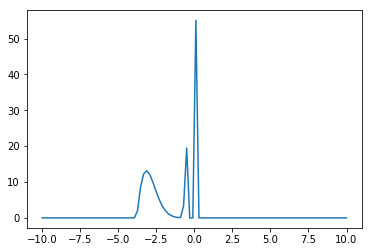

In [78]:
plt.plot(logit_theta, np.exp(log_phi_pos(logit_theta)))

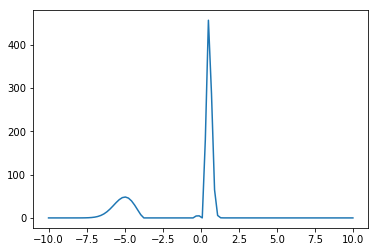

In [80]:
plt.plot(logit_theta, np.exp(log_phi_neg(logit_theta)))

In [145]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, 
                                                    log_phi = log_phi_pos,
                                                    logit_v_ub = 10,
                                                    logit_v_lb = -10)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.233178e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.849005e-01
  AccuracyWarning)


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.233178e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.849005e-01
  AccuracyWarning)


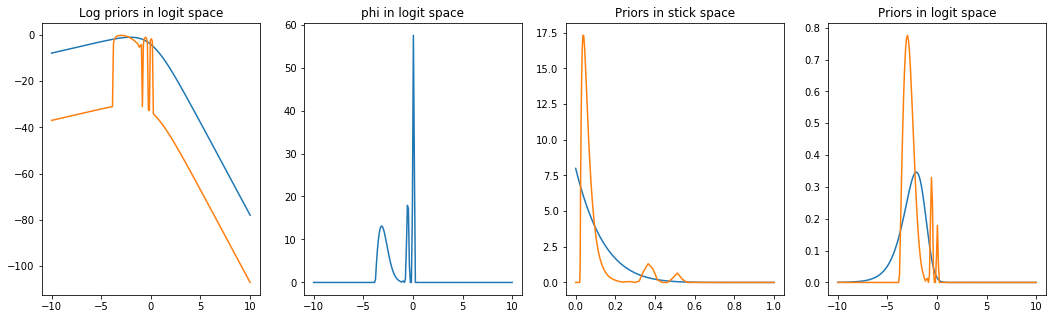

In [146]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                           prior_perturbation.logit_v_ub, 
                           200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


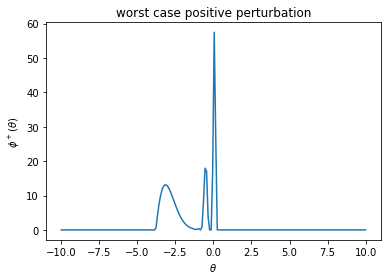

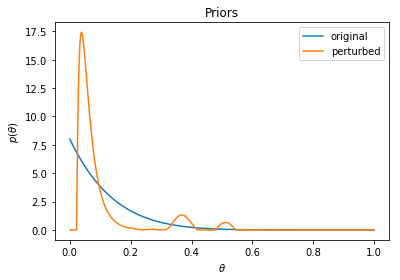

In [147]:
plt.figure()
v_grid = np.linspace(0.000001, 0.99999, 500)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.ylabel('$\phi^+(\\theta)$')
plt.xlabel('$\\theta$')
plt.title('worst case positive perturbation')

# plt.savefig('../../../writing/functional_sensitivity_writing/func_sens_results/worst_case_neg_pert.png')

plt.figure()
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors')
plt.xlabel('$\\theta$')
plt.ylabel('$p(\\theta)$')
plt.legend(('original', 'perturbed'))
plt.savefig('../../../writing/functional_sensitivity_writing/func_sens_results/worst_case_pos_priors.png')


In [119]:
# This expects the hyperparameter to be at its optimal value.
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [120]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

2.672191398209073

# Fit with perturbation

In [121]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  2.672191398209073


In [122]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)
print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.233178e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.849005e-01
  AccuracyWarning)


epsilon: 1.0
Iter  0  value:  -203.92357111082777
Iter  1  value:  -204.82703733119854
Iter  2  value:  -205.39256856145997
Iter  3  value:  -205.43338671180592
Iter  4  value:  -205.7351687149787
Iter  5  value:  -205.95586149552463
Iter  6  value:  -213.39712071776833
Iter  7  value:  -213.65385372350818
Iter  8  value:  -213.70513272812303
Iter  9  value:  -213.74912955252657
Iter  10  value:  -213.74655778722473
Iter  11  value:  -213.74655778722473
Iter  12  value:  -213.75329639096475
Iter  13  value:  -213.7619726062538
Iter  14  value:  -213.7666311265922
Iter  15  value:  -213.76769256483828
Iter  16  value:  -213.76770068439
Iter  17  value:  -213.76770084433335
Iter  18  value:  -213.76770084433775
Optimization terminated successfully.
         Current function value: -213.767701
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 17
         Hessian evaluations: 0
Iter  19  value:  -213.7677008443373
Iter  20  value:  -213.76770084433582

In [123]:
# Get e_num_clusters before and after perturbation
output_phi = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi)
output_0 = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_0)

# Check results

Epsilon: 1.0


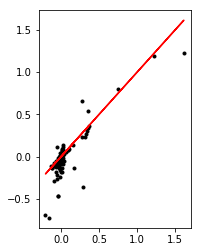

In [124]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [125]:
output_0

array([8.51622147])

In [126]:
output_phi 

array([9.11433631])

In [127]:
output_phi_pred

array([8.79695022])

# Fit with range of perturbations

In [128]:
epsilon_vec = np.linspace(0.1, 1.0, 10)
# epsilon_vec = np.linspace(0.02, 0.2, 10)
print(epsilon_vec)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [129]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [130]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('Epsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
        epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

    output_phi = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi)

    print('Done. Converged: ', converged)

    print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    

Epsilon:  0.1
Predicted differences:  0.2672191398209074
epsilon: 0.1


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.206893e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.376000e-02
  AccuracyWarning)


Iter  21  value:  -293.0158774300295
Iter  22  value:  -293.0249582250517
Iter  23  value:  -293.02558010443016
Iter  24  value:  -293.0256817607018
Iter  25  value:  -293.0256850585079
Iter  26  value:  -293.025685080694
Iter  27  value:  -293.02568508071283
Optimization terminated successfully.
         Current function value: -293.025685
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0
Iter  28  value:  -293.02568508071334
Iter  29  value:  -293.0256850807133
         Current function value: -293.025685
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 0.1681316007115973
Epsilon:  0.2
Predicted differences:  0.5344382796418146
epsilon: 0.2


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.788184e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.228560e-01
  AccuracyWarning)


Iter  30  value:  -280.63959311472485
Iter  31  value:  -280.6926831731843
Iter  32  value:  -280.70356136487794
Iter  33  value:  -280.70594872895356
Iter  34  value:  -280.70610174315516
Iter  35  value:  -280.70610949107015
Iter  36  value:  -280.70610952934743
Iter  37  value:  -280.70610952934817
Optimization terminated successfully.
         Current function value: -280.706110
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 0
Iter  38  value:  -280.7061095293478
Iter  39  value:  -280.70610952934913
         Current function value: -280.706110
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 0.2845928279219736
Epsilon:  0.30000000000000004
Predicted differences:  0.8016574194627218
epsilon: 0.30000000000000004


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.054541e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.544308e-01
  AccuracyWarning)


Iter  40  value:  -269.4771528486927
Iter  41  value:  -270.99180550898586
Iter  42  value:  -271.02789636152943
Iter  43  value:  -271.0457874372294
Iter  44  value:  -271.09494216219167
Iter  45  value:  -271.13006097072963
Iter  46  value:  -271.1458934592851
Iter  47  value:  -271.16672053446825
Iter  48  value:  -271.17723677610894
Iter  49  value:  -271.1792952755487
Iter  50  value:  -271.17937247787376
Iter  51  value:  -271.1793729156562
Iter  52  value:  -271.17937291594706
Optimization terminated successfully.
         Current function value: -271.179373
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
         Hessian evaluations: 0
Iter  53  value:  -271.17937291594467
Iter  54  value:  -271.17937291594797
Optimization terminated successfully.
         Current function value: -271.179373
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
T

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.374798e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.945134e-01
  AccuracyWarning)


Iter  55  value:  -256.87758377579524
Iter  56  value:  -258.9931559832112
Iter  57  value:  -259.0401948054051
Iter  58  value:  -259.7276993655711
Iter  59  value:  -259.74484441788877
Iter  60  value:  -259.7619945598993
Iter  61  value:  -259.778867323802
Iter  62  value:  -259.7939838546201
Iter  63  value:  -259.7819322683107
Iter  64  value:  -259.7819322683107
Iter  65  value:  -259.7819322683107
Iter  66  value:  -259.7977433203132
Iter  67  value:  -259.8019811171677
Iter  68  value:  -259.80677812495423
Iter  69  value:  -259.8134828551323
Iter  70  value:  -259.8150859684831
Iter  71  value:  -259.80377030815924
Iter  72  value:  -259.8181102222444
Iter  73  value:  -259.8183613237449
Iter  74  value:  -259.8229370697084
Iter  75  value:  -259.8278826323973
Iter  76  value:  -259.8285029979465
Iter  77  value:  -259.82856034483416
Iter  78  value:  -259.8285604146379
Iter  79  value:  -259.8285604146406
Optimization terminated successfully.
         Current function value: 

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.751887e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.460725e-01
  AccuracyWarning)


Iter  82  value:  -248.35577265957286
Iter  83  value:  -251.08735046077476
Iter  84  value:  -251.12859972379005
Iter  85  value:  -251.1925834774573
Iter  86  value:  -251.24893093385384
Iter  87  value:  -251.26744679128493
Iter  88  value:  -251.27127084124274
Iter  89  value:  -251.27458259643225
Iter  90  value:  -251.3387309769841
Iter  91  value:  -251.3580786257734
Iter  92  value:  -251.35930081320342
Iter  93  value:  -251.359308654785
Iter  94  value:  -251.3593087035808
Iter  95  value:  -251.3593087035838
Optimization terminated successfully.
         Current function value: -251.359309
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 0
Iter  96  value:  -251.3593087035834
Iter  97  value:  -251.35930870358305
         Current function value: -251.359309
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.172992e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.129918e-01
  AccuracyWarning)


Iter  98  value:  -239.04727190824727
Iter  99  value:  -239.4098415881147
Iter  100  value:  -239.46610965164055
Iter  101  value:  -239.4717272649446
Iter  102  value:  -239.4720288301361
Iter  103  value:  -239.47204713020128
Iter  104  value:  -239.47204721126843
Iter  105  value:  -239.47204721128455
Optimization terminated successfully.
         Current function value: -239.472047
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 0
Iter  106  value:  -239.4720472112834
Iter  107  value:  -239.47204721128304
         Current function value: -239.472047
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.5377079496831605
Epsilon:  0.7000000000000001
Predicted differences:  1.8705339787463509
epsilon: 0.7000000000000001


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.630612e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.007690e-01
  AccuracyWarning)


Iter  108  value:  -229.16546745230005
Iter  109  value:  -229.66153224838553
Iter  110  value:  -229.7369526059589
Iter  111  value:  -229.7569799924807
Iter  112  value:  -229.7613435485868
Iter  113  value:  -229.7618624312641
Iter  114  value:  -229.76186907828824
Iter  115  value:  -229.76186910011995
Iter  116  value:  -229.76186910012342
Optimization terminated successfully.
         Current function value: -229.761869
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 0
Iter  117  value:  -229.76186910012285
Iter  118  value:  -229.7618691001228
         Current function value: -229.761869
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.853992109879599
Epsilon:  0.8
Predicted differences:  2.1377531185672587
epsilon: 0.8


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.123227e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.172011e-01
  AccuracyWarning)


Iter  119  value:  -218.1275805540143
Iter  120  value:  -218.87394547099265
Iter  121  value:  -218.98517634419542
Iter  122  value:  -219.02631830924787
Iter  123  value:  -219.03786348688908
Iter  124  value:  -219.05545604707694
Iter  125  value:  -219.0587825389044
Iter  126  value:  -219.05931852115748
Iter  127  value:  -219.05932464013773
Iter  128  value:  -219.0593246468069
Optimization terminated successfully.
         Current function value: -219.059325
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 0
Iter  129  value:  -219.05932464680674
Iter  130  value:  -219.05932464680893
Optimization terminated successfully.
         Current function value: -219.059325
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.9653067317450836
Epsilon:  0.9
Predicted differences:  2.404972

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.654714e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.733460e-01
  AccuracyWarning)


Iter  131  value:  -214.06261237494172
Iter  132  value:  -214.78491832896452
Iter  133  value:  -214.8466265979789
Iter  134  value:  -214.87606347167753
Iter  135  value:  -215.237658839353
Iter  136  value:  -215.24827261842313
Iter  137  value:  -215.26232795754098
Iter  138  value:  -215.36386211895595
Iter  139  value:  -215.4749171623251
Iter  140  value:  -215.54030463452125
Iter  141  value:  -215.56231303585844
Iter  142  value:  -215.56382530909303
Iter  143  value:  -215.56383170477858
Iter  144  value:  -215.56383171176094
Optimization terminated successfully.
         Current function value: -215.563832
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 0
Iter  145  value:  -215.56383171176066
Iter  146  value:  -215.5638317117627
Optimization terminated successfully.
         Current function value: -215.563832
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
  

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.233178e-02
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.849005e-01
  AccuracyWarning)


Iter  147  value:  -203.92357111082777
Iter  148  value:  -204.82703733119854
Iter  149  value:  -205.39256856145997
Iter  150  value:  -205.43338671180592
Iter  151  value:  -205.7351687149787
Iter  152  value:  -205.95586149552463
Iter  153  value:  -213.39712071776833
Iter  154  value:  -213.65385372350818
Iter  155  value:  -213.70513272812303
Iter  156  value:  -213.74912955252657
Iter  157  value:  -213.74655778722473
Iter  158  value:  -213.74655778722473
Iter  159  value:  -213.75329639096475
Iter  160  value:  -213.7619726062538
Iter  161  value:  -213.7666311265922
Iter  162  value:  -213.76769256483828
Iter  163  value:  -213.76770068439
Iter  164  value:  -213.76770084433335
Iter  165  value:  -213.76770084433775
Optimization terminated successfully.
         Current function value: -213.767701
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 17
         Hessian evaluations: 0
Iter  166  value:  -213.7677008443373
Iter  167  value:  -

In [131]:
np.save('worst_case_pos_results', best_param_phi_array)
np.save('worst_case_pos_epsilons', epsilon_vec)

In [132]:
output_0 = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_0)

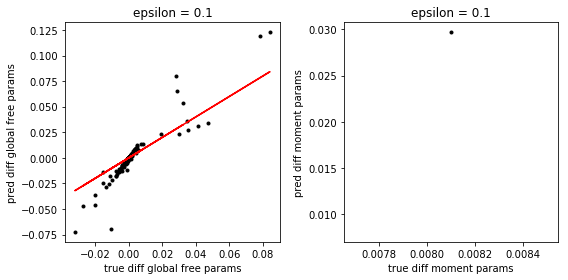

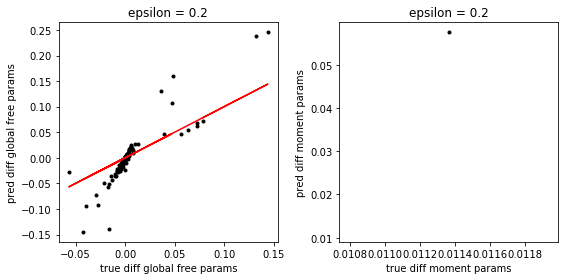

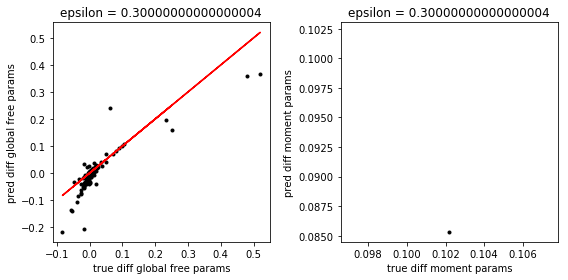

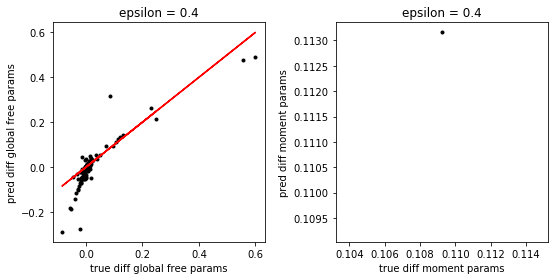

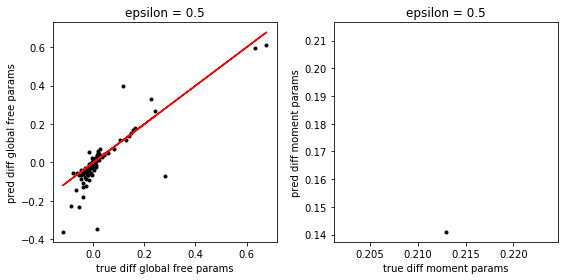

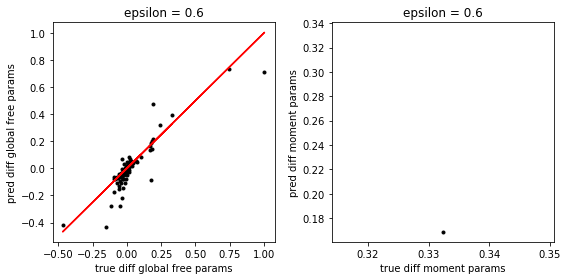

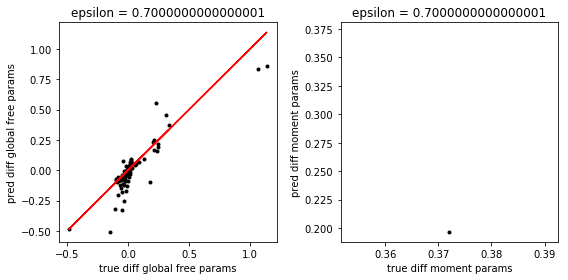

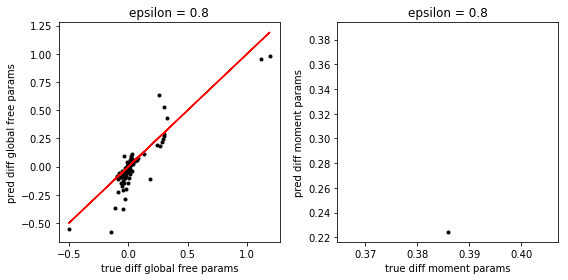

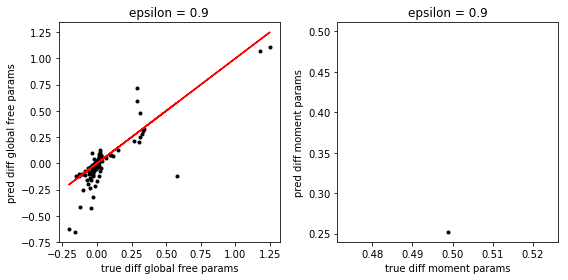

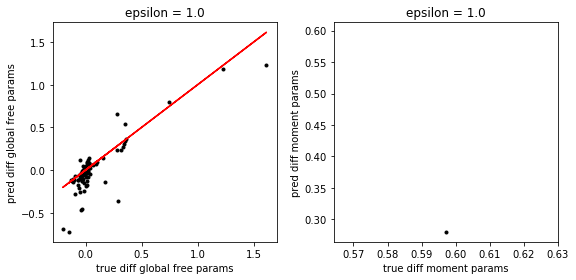

In [133]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_pred_array[i] - best_param_0, 'k.')
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_array[i] - best_param_0, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.subplot(1, 2, 2)
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_pred_array[i] - output_0, 'k.')
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_array[i] - output_0, 'r')
    plt.xlabel('true diff moment params')
    plt.ylabel('pred diff moment params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
    plt.tight_layout()

    

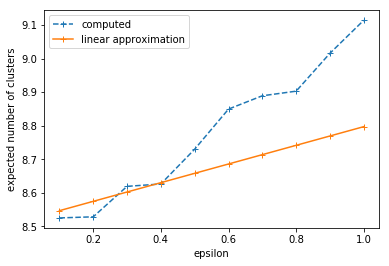

In [134]:
plt.plot(epsilon_vec, output_phi_array, '+--')
plt.plot(epsilon_vec, output_phi_pred_array, '+-')


plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

plt.legend(('computed', 'linear approximation'))

plt.savefig('../../../writing/functional_sensitivity_writing/func_sens_results/worst_case_pos_influence_results.png')

In [135]:
output_phi_pred_nonlin_array = []
for i in range(len(epsilon_vec)): 
    output_phi_pred_nonlin_array.append(
        epsilon_sensitivity.predict_output_par_from_hyperparameters(epsilon_vec[i], linear = False))

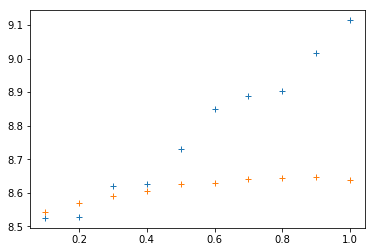

In [136]:
plt.plot(epsilon_vec, output_phi_array, '+')
plt.plot(epsilon_vec, output_phi_pred_nonlin_array, '+')